## Прогнозирование размеров сварного шва при электронно-лучевой сварке тонкостенных конструкций

В качестве исходных данных были взяты результаты экспериментальных исследований, проводимых в целях улучшения технологического процесса электронно-лучевой сварки изделия, сборка которого состоит из элементов, состоящих из разнородного материала. Установка электронно-лучевой сварки, на которой проводились исследования, предназначена для сварки электронным лучом в глубоком вакууме деталей сборочных единиц из нержавеющих сталей, титановых, алюминиевых и специальных сплавов. Существующая установка электронно-лучевой сварки обеспечивает повторяемость режимов в рамках возможностей реализованной системы управления. Работы по сварке выполнялись на образцах-имитаторах, соответствующих технологическому изделию. Для уменьшения вложения энергии при сварке: 

   1. Снижалась величина сварочного тока (IW); \
   2. Увеличивался ток фокусировки электронного пучка (IF); 
   3. Увеличивалась скорость сварки (VW); 
   4. Менялось расстояние от поверхности образцов до электронно-оптической системы (FP).  

Требуется: провести прогнозирование глубины (Depth) и ширины (Width) сварного шва в зависимости от параметров технологического процесса (IW, IF, VW, FP). 

In [1]:
# выгружаем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import numpy as np
from scipy import stats as st
import math as mth
import seaborn as sns
import datetime as dt
import plotly.express as px
from plotly import graph_objects as go
from matplotlib.colors import LogNorm
import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import itertools
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,  BatchNormalization
from tensorflow.keras.layers import Normalization, LayerNormalization
from tensorflow.keras.optimizers import Adam
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
!pip freeze

numpy==1.21.6
pandas==1.3.5
Pillow==6.0.0
python-dateutil==2.8.2
pytz==2022.1
six==1.16.0


In [3]:
!pip freeze > requirements.txt

### 1. Предварительная обработка датасета

In [4]:
# выгружаем данные и информацию о них
data = pd.read_csv('ebw_data.csv')
display(data.head(10))
data.info()

,IW,IF,VW,FP,Depth,Width
0,47,139,4.5,80,1.60,2.54
1,47,139,4.5,80,1.62,2.50
2,47,139,4.5,80,1.68,2.60
3,47,139,4.5,80,1.58,2.52
4,45,140,4.5,80,1.76,2.48
5,45,140,4.5,80,1.72,2.48
6,45,140,4.5,80,1.64,2.52
7,45,140,4.5,80,1.64,2.56
8,45,140,8.0,80,1.20,2.00
9,45,140,8.0,80,1.20,1.96


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


Датасет описывает результаты экспериментальных исследований, проводимых в целях улучшения технологического процесса электронно-лучевой сварки изделия, сборка которого состоит из элементов, состоящих из разнородного материала.

Колонки в  *ebw_data.csv* :

- `IW` — величина сварочного тока;
- `IF` — ток фокусировки электронного пучка;
- `VW` — скорость сварки;
- `FP` — расстояние от поверхности образцов до электронно-оптической системы;
- `Depth` — глубина шва;
- `Width` — ширина шва.

Пойдем по чек-листу для предобработки: 

1.1 Исследовать пропущенные значения и заменить пропуски - пропусков нет;
    
1.2 Исследовать соответствие типов и привести типы - у всех столбцов, на первый взгляд, приемлемый формат;

1.3 Проверить корректность наименований колонок и переименовать колонки - колонки называются корректно;

1.4 Исследовать дубликаты:

In [5]:
# проверка на дубликаты
print('Количество дубликатов:', data.duplicated().sum())

Количество дубликатов: 7


In [6]:
# удаляем дубликаты
#data = data.drop_duplicates().reset_index(drop=True)

Дубликаты не удаляем, т.к. не исключено получение одинаковых значений по разным экспериментам, а данных достаточно мало.

In [7]:
# посмотрим на описательную статистику 
data.describe()

,IW,IF,VW,FP,Depth,Width
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,45.666667,141.333333,8.638889,78.333333,1.195556,1.970417
std,1.678363,5.145763,2.061078,21.493530,0.225081,0.279040
min,43.000000,131.000000,4.500000,50.000000,0.800000,1.680000
25%,44.000000,139.000000,8.000000,60.000000,1.080000,1.760000
50%,45.500000,141.000000,9.000000,80.000000,1.200000,1.840000
75%,47.000000,146.000000,10.000000,80.000000,1.290000,2.050000
max,49.000000,150.000000,12.000000,125.000000,1.760000,2.600000


Средняя глубина сварного шва 1.19, а ширина 1.97. Разброс между размерами глубины и ширины достаточно большой, необходимо будет проверить выборку на выбросы. Но сначала посмотрим на корреляцию признаков.

<AxesSubplot:>

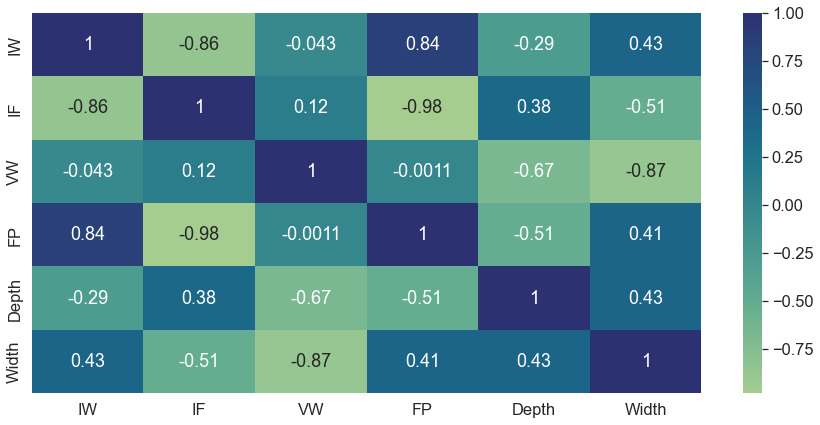

In [8]:
#построим корреляционную матрицу
corr = data.corr()
sns.set(font_scale=1.5) 
f, ax = plt.subplots(figsize=(15,7))
sns.heatmap(corr, annot=True, ax=ax, cmap="crest")

Видна значительная корреляция между FP - расстоянием от поверхности образцов до электронно-оптической системы и IW - величиной сварочного тока. Это можно объяснить тем, что при приближении к поверхности образцов, величина сварочного тока будет увеличиваться.

Что касается искомых ширины и глубины - больших значений корреляции не наблюдаем, но можно обратить внимание на отрицательную корреляцию -0,87 между шириной шва и скоростью сварки. Отрицательная корреляция означает, что чем больше скорость сварки, тем меньше ширина шва.

Проверим также распределение глубины и ширины на нормальность.

<AxesSubplot:xlabel='Depth', ylabel='Density'>

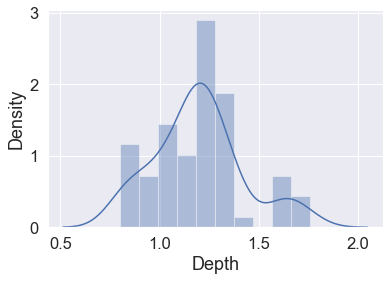

In [9]:
#проверим нормальность распределения глубины шва
sns.distplot(data['Depth'])

<AxesSubplot:xlabel='Width', ylabel='Density'>

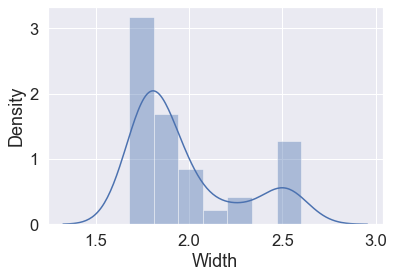

In [10]:
#проверим нормальность распределения ширины шва
sns.distplot(data['Width'])

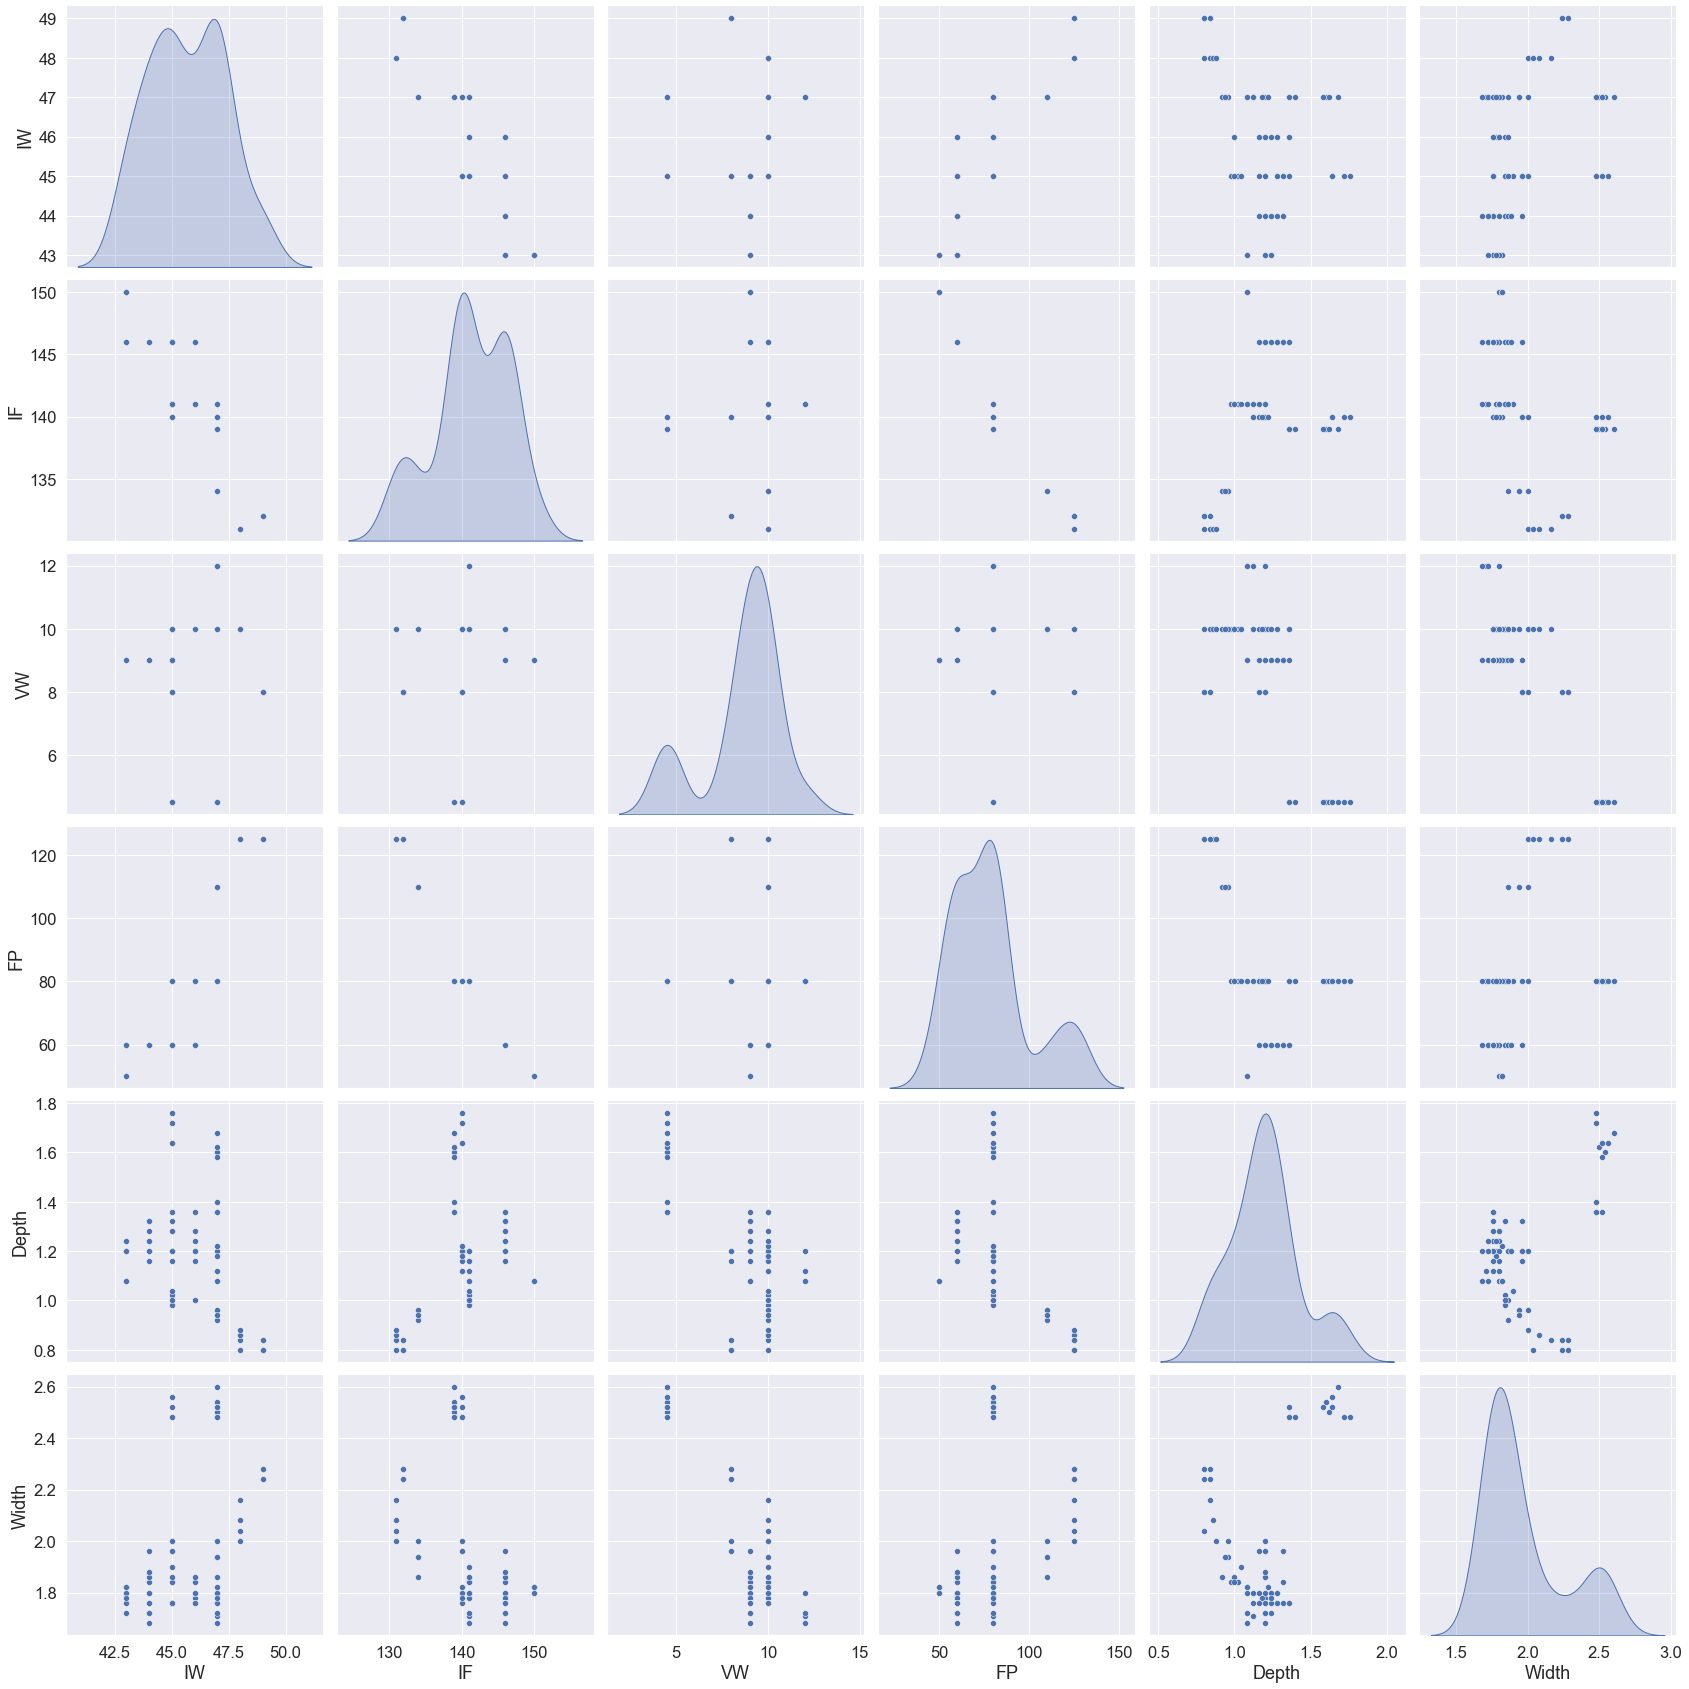

In [11]:
#Попарные графики рассеяния
sns.pairplot(data, height=4, diag_kind='kde');

Нельзя сказать, что данные распределены нормально, поэтому в дальнейшем используем нормализацию данных.

In [12]:
# стандартизируем данные
scaler = StandardScaler()
# обучаем и трансформируем данные
scaler.fit(data)
data_standard = scaler.transform(np.array(data[['IW', 'IF', 'VW', 'FP', 'Depth', 'Width']]))
data_standard = pd.DataFrame(data = data_standard, columns = ['IW', 'IF', 'VW', 'FP', 'Depth', 'Width'] )

In [13]:
#Видно что данные находятся в разных диапазонах 
#данные нужно нормализовать
scaler = preprocessing.MinMaxScaler()
names = data_standard.columns
d = scaler.fit_transform(data_standard)
data_standard_norm = pd.DataFrame(d, columns=names).round(2)
data_standard_norm.head()
#Описательная статистика характеристик после нормализации
print(data_standard_norm.describe().T.round(2))
data_standard_norm.info()

       count  mean   std  min   25%   50%   75%  max
IW      72.0  0.45  0.28  0.0  0.17  0.42  0.67  1.0
IF      72.0  0.54  0.27  0.0  0.42  0.53  0.79  1.0
VW      72.0  0.55  0.27  0.0  0.47  0.60  0.73  1.0
FP      72.0  0.38  0.29  0.0  0.13  0.40  0.40  1.0
Depth   72.0  0.41  0.23  0.0  0.29  0.42  0.51  1.0
Width   72.0  0.32  0.30  0.0  0.09  0.17  0.40  1.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     float64
 1   IF      72 non-null     float64
 2   VW      72 non-null     float64
 3   FP      72 non-null     float64
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(6)
memory usage: 3.5 KB


Оценим выбросы в выборке. Сравненим два метода удаления выбросов: 3-х сигм или межквартильных расстояний.

In [14]:
sgm = 0
iqd= 0
for column in data_standard_norm:
    df = data_standard_norm.loc[:, [column]]
# методом 3-х сигм
zscore = (data_standard_norm[column] - data_standard_norm[column].mean())
/ data_standard_norm[column].std()
df['3s'] = zscore.abs() > 3
sgm += df['3s'].sum()
# методом межквартильных расстояний
q1 = np.quantile(data_standard_norm[column], 0.25)
q3 = np.quantile(data_standard_norm[column], 0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
df['iq'] = (data_standard_norm[column] <= lower) | (data_standard_norm[column] >= upper)
iqd+= df['iq'].sum()
print( sgm,'-- выброс методом 3-х сигм',)
print( iqd,'-- выброс методом межквартильных расстояний',)

0 -- выброс методом 3-х сигм
12 -- выброс методом межквартильных расстояний


In [15]:
#Удаление выбросов
#убираем из датасета только те записи, для которых все Z-оценки лежат в интервале [-3, 3]
data_standard_norm = data_standard_norm[(np.abs(st.zscore(data_standard_norm)) <= 3).all(axis=1)] 
data_standard_norm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     float64
 1   IF      72 non-null     float64
 2   VW      72 non-null     float64
 3   FP      72 non-null     float64
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(6)
memory usage: 3.9 KB


Мы стандартизировали и нормализировали данные, посмотрели на описательную статистику, определили и удалили выбросы и решили, что не будем удалять дубликаты. Теперь применим к данным алгоритмы машинного обучения.

###  2. Применение алгоритмов машинного обучения

Используем регрессионные алгоритмы: линейную регрессию, лассо-регрессию и многослойный перцептрон.

In [16]:
#Входы и выходы для моделей
output_depth = data_standard_norm['Depth']
output_width = data_standard_norm['Width']
#input_depth = data_standard.loc[:, data_standard.columns != 'Depth']
#input_width = data_standard.loc[:, data_standard.columns != 'Width']

input_depth = data_standard_norm[['IW', 'IF', 'VW', 'FP']]
input_width = input_depth
#Разделяем датасет на обучающую и тестовую выборки
X_input_depth, X_output_depth, y_input_depth, y_output_depth = train_test_split(input_depth, output_depth, test_size=0.3, random_state=42)
X_input_width, X_output_width, y_input_width, y_output_width = train_test_split(input_width, output_width, test_size=0.3, random_state=42)
data_standard_norm.shape[0] - X_input_depth.shape[0] - X_output_depth.shape[0]
data_standard_norm.shape[0] - X_input_width.shape[0] - X_output_width.shape[0]
#Итоговый датасет ошибок
errors_df = pd.DataFrame(columns=['target_var','model_name','MSE','R2'])
#Определение функции для визуализации
def actual_and_predicted_plot(orig, predict, var, model_name):
    plt.figure(figsize=(17,5))
    plt.title(f'Тестовые и прогнозные значения: {model_name}')
    plt.plot(orig, label='Тест')
    plt.plot(predict, label='Прогноз')
    plt.legend(loc='best')
    plt.ylabel(var)
    plt.xlabel('Количество наблюдений')
    plt.show()
#Линейная регрессия
# глубина шва
linear_model_depth = LinearRegression()
linear_model_depth.fit(X_input_depth, y_input_depth)
prediction_y_test_linear_1 = linear_model_depth.predict(X_output_depth)
MSE_depth = mean_squared_error(y_output_depth, prediction_y_test_linear_1)
R2_depth = r2_score(y_output_depth, prediction_y_test_linear_1)
# ширина шва
linear_model_width = LinearRegression()
linear_model_width.fit(X_input_width, y_input_width)
prediction_y_test_linear_2 = linear_model_width.predict(X_output_width)
MSE_width = mean_squared_error(y_output_width, prediction_y_test_linear_2)
R2_width = r2_score(y_output_width, prediction_y_test_linear_2)
linear_errors = pd.DataFrame({'model_name':'Linear Regression',\
                              'target_var':['Depth', 'Width'],\
                              'MSE':[MSE_depth, MSE_width],\
                              'R2':[R2_depth, R2_width]})
errors_df = pd.concat([errors_df, linear_errors], ignore_index=True)
errors_df

,target_var,model_name,MSE,R2
0,Depth,Linear Regression,0.018814,0.696409
1,Width,Linear Regression,0.004331,0.95685


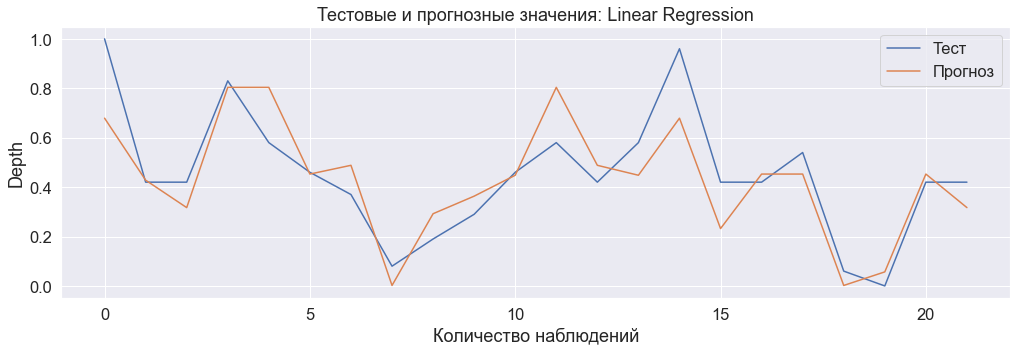

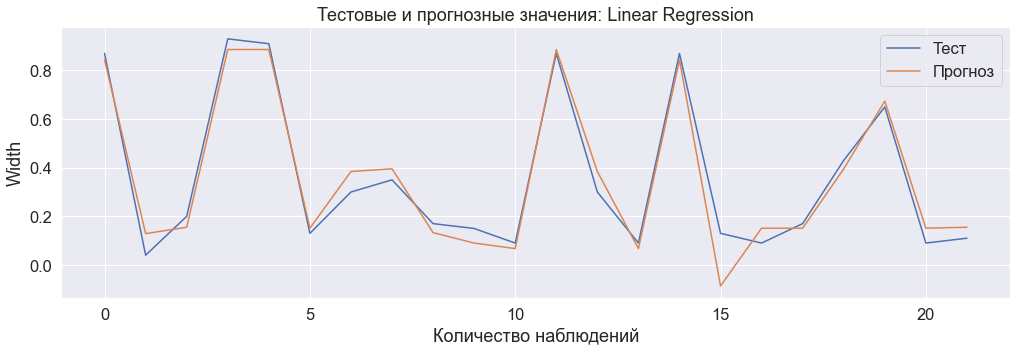

In [17]:
#Визуализация
actual_and_predicted_plot(y_output_depth.values, prediction_y_test_linear_1, 'Depth', 'Linear Regression')
actual_and_predicted_plot(y_output_width.values, prediction_y_test_linear_2, 'Width', 'Linear Regression')

In [18]:
#Лассо регрессия
lasso_model = Lasso(random_state=14)
lasso_model_params = {'alpha': np.linspace(0, 1, 100)}
GSCV_lasso_model_depth = GridSearchCV(lasso_model, lasso_model_params, cv=10, verbose=2)
GSCV_lasso_model_depth.fit(X_input_depth, y_input_depth)
# GSCV_lasso_model_upr.best_params_
lasso_model_depth = GSCV_lasso_model_depth.best_estimator_
MSE_depth = mean_squared_error(y_output_depth, lasso_model_depth.predict(X_output_depth))
R2_depth = r2_score(y_output_depth, lasso_model_depth.predict(X_output_depth))
GSCV_lasso_model_width = GridSearchCV(lasso_model, lasso_model_params, cv=10, verbose=2)
GSCV_lasso_model_width.fit(X_input_width, y_input_width)
# GSCV_lasso_model_pro.best_params_
lasso_model_width = GSCV_lasso_model_width.best_estimator_
MSE_width = mean_squared_error(y_output_width, lasso_model_width.predict(X_output_width))
R2_width = r2_score(y_output_width, lasso_model_width.predict(X_output_width))
lasso_model_errors = pd.DataFrame({'model_name':'lasso_model',\
                                   'target_var':['Depth', 'Width'],\
                                   'MSE':[MSE_depth, MSE_width],\
                                   'R2':[R2_depth, R2_width]})
errors_df = pd.concat([errors_df, lasso_model_errors], ignore_index=True)
errors_df                             

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] END ..........................................alpha=0.0; total time=   0.0s
[CV] END ..........................................alpha=0.0; total time=   0.0s
[CV] END ..........................................alpha=0.0; total time=   0.0s
[CV] END ..........................................alpha=0.0; total time=   0.0s
[CV] END ..........................................alpha=0.0; total time=   0.0s
[CV] END ..........................................alpha=0.0; total time=   0.0s
[CV] END ..........................................alpha=0.0; total time=   0.0s
[CV] END ..........................................alpha=0.0; total time=   0.0s
[CV] END ..........................................alpha=0.0; total time=   0.0s
[CV] END ..........................................alpha=0.0; total time=   0.0s
[CV] END .........................alpha=0.010101010101010102; total time=   0.0s
[CV] END .........................alpha=0.01

[CV] END ..........................alpha=0.10101010101010102; total time=   0.0s
[CV] END ..........................alpha=0.10101010101010102; total time=   0.0s
[CV] END ..........................alpha=0.10101010101010102; total time=   0.0s
[CV] END ..........................alpha=0.10101010101010102; total time=   0.0s
[CV] END ..........................alpha=0.10101010101010102; total time=   0.0s
[CV] END ..........................alpha=0.10101010101010102; total time=   0.0s
[CV] END ..........................alpha=0.10101010101010102; total time=   0.0s
[CV] END ..........................alpha=0.10101010101010102; total time=   0.0s
[CV] END ..........................alpha=0.10101010101010102; total time=   0.0s
[CV] END ..........................alpha=0.11111111111111112; total time=   0.0s
[CV] END ..........................alpha=0.11111111111111112; total time=   0.0s
[CV] END ..........................alpha=0.11111111111111112; total time=   0.0s
[CV] END ...................

[CV] END ..........................alpha=0.21212121212121213; total time=   0.0s
[CV] END ..........................alpha=0.22222222222222224; total time=   0.0s
[CV] END ..........................alpha=0.22222222222222224; total time=   0.0s
[CV] END ..........................alpha=0.22222222222222224; total time=   0.0s
[CV] END ..........................alpha=0.22222222222222224; total time=   0.0s
[CV] END ..........................alpha=0.22222222222222224; total time=   0.0s
[CV] END ..........................alpha=0.22222222222222224; total time=   0.0s
[CV] END ..........................alpha=0.22222222222222224; total time=   0.0s
[CV] END ..........................alpha=0.22222222222222224; total time=   0.0s
[CV] END ..........................alpha=0.22222222222222224; total time=   0.0s
[CV] END ..........................alpha=0.22222222222222224; total time=   0.0s
[CV] END ..........................alpha=0.23232323232323235; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.3434343434343435; total time=   0.0s
[CV] END ...........................alpha=0.3434343434343435; total time=   0.0s
[CV] END ...........................alpha=0.3434343434343435; total time=   0.0s
[CV] END ...........................alpha=0.3434343434343435; total time=   0.0s
[CV] END ...........................alpha=0.3434343434343435; total time=   0.0s
[CV] END ...........................alpha=0.3434343434343435; total time=   0.0s
[CV] END ...........................alpha=0.3434343434343435; total time=   0.0s
[CV] END ...........................alpha=0.3434343434343435; total time=   0.0s
[CV] END ...........................alpha=0.3535353535353536; total time=   0.0s
[CV] END ...........................alpha=0.3535353535353536; total time=   0.0s
[CV] END ...........................alpha=0.3535353535353536; total time=   0.0s
[CV] END ...........................alpha=0.3535353535353536; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.4444444444444445; total time=   0.0s
[CV] END ...........................alpha=0.4545454545454546; total time=   0.0s
[CV] END ...........................alpha=0.4545454545454546; total time=   0.0s
[CV] END ...........................alpha=0.4545454545454546; total time=   0.0s
[CV] END ...........................alpha=0.4545454545454546; total time=   0.0s
[CV] END ...........................alpha=0.4545454545454546; total time=   0.0s
[CV] END ...........................alpha=0.4545454545454546; total time=   0.0s
[CV] END ...........................alpha=0.4545454545454546; total time=   0.0s
[CV] END ...........................alpha=0.4545454545454546; total time=   0.0s
[CV] END ...........................alpha=0.4545454545454546; total time=   0.0s
[CV] END ...........................alpha=0.4545454545454546; total time=   0.0s
[CV] END ...........................alpha=0.4646464646464647; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.5555555555555556; total time=   0.0s
[CV] END ...........................alpha=0.5656565656565657; total time=   0.0s
[CV] END ...........................alpha=0.5656565656565657; total time=   0.0s
[CV] END ...........................alpha=0.5656565656565657; total time=   0.0s
[CV] END ...........................alpha=0.5656565656565657; total time=   0.0s
[CV] END ...........................alpha=0.5656565656565657; total time=   0.0s
[CV] END ...........................alpha=0.5656565656565657; total time=   0.0s
[CV] END ...........................alpha=0.5656565656565657; total time=   0.0s
[CV] END ...........................alpha=0.5656565656565657; total time=   0.0s
[CV] END ...........................alpha=0.5656565656565657; total time=   0.0s
[CV] END ...........................alpha=0.5656565656565657; total time=   0.0s
[CV] END ...........................alpha=0.5757575757575758; total time=   0.0s
[CV] END ...................

[CV] END ............................alpha=0.686868686868687; total time=   0.0s
[CV] END ............................alpha=0.686868686868687; total time=   0.0s
[CV] END ............................alpha=0.686868686868687; total time=   0.0s
[CV] END ............................alpha=0.686868686868687; total time=   0.0s
[CV] END ............................alpha=0.686868686868687; total time=   0.0s
[CV] END ............................alpha=0.686868686868687; total time=   0.0s
[CV] END ............................alpha=0.696969696969697; total time=   0.0s
[CV] END ............................alpha=0.696969696969697; total time=   0.0s
[CV] END ............................alpha=0.696969696969697; total time=   0.0s
[CV] END ............................alpha=0.696969696969697; total time=   0.0s
[CV] END ............................alpha=0.696969696969697; total time=   0.0s
[CV] END ............................alpha=0.696969696969697; total time=   0.0s
[CV] END ...................

[CV] END ............................alpha=0.797979797979798; total time=   0.0s
[CV] END ............................alpha=0.797979797979798; total time=   0.0s
[CV] END ............................alpha=0.797979797979798; total time=   0.0s
[CV] END ............................alpha=0.797979797979798; total time=   0.0s
[CV] END ............................alpha=0.797979797979798; total time=   0.0s
[CV] END ............................alpha=0.797979797979798; total time=   0.0s
[CV] END ............................alpha=0.797979797979798; total time=   0.0s
[CV] END ...........................alpha=0.8080808080808082; total time=   0.0s
[CV] END ...........................alpha=0.8080808080808082; total time=   0.0s
[CV] END ...........................alpha=0.8080808080808082; total time=   0.0s
[CV] END ...........................alpha=0.8080808080808082; total time=   0.0s
[CV] END ...........................alpha=0.8080808080808082; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.8989898989898991; total time=   0.0s
[CV] END ...........................alpha=0.8989898989898991; total time=   0.0s
[CV] END ...........................alpha=0.9090909090909092; total time=   0.0s
[CV] END ...........................alpha=0.9090909090909092; total time=   0.0s
[CV] END ...........................alpha=0.9090909090909092; total time=   0.0s
[CV] END ...........................alpha=0.9090909090909092; total time=   0.0s
[CV] END ...........................alpha=0.9090909090909092; total time=   0.0s
[CV] END ...........................alpha=0.9090909090909092; total time=   0.0s
[CV] END ...........................alpha=0.9090909090909092; total time=   0.0s
[CV] END ...........................alpha=0.9090909090909092; total time=   0.0s
[CV] END ...........................alpha=0.9090909090909092; total time=   0.0s
[CV] END ...........................alpha=0.9090909090909092; total time=   0.0s
[CV] END ...................

[CV] END ..........................................alpha=0.0; total time=   0.0s
[CV] END ..........................................alpha=0.0; total time=   0.0s
[CV] END ..........................................alpha=0.0; total time=   0.0s
[CV] END ..........................................alpha=0.0; total time=   0.0s
[CV] END ..........................................alpha=0.0; total time=   0.0s
[CV] END ..........................................alpha=0.0; total time=   0.0s
[CV] END ..........................................alpha=0.0; total time=   0.0s
[CV] END .........................alpha=0.010101010101010102; total time=   0.0s
[CV] END .........................alpha=0.010101010101010102; total time=   0.0s
[CV] END .........................alpha=0.010101010101010102; total time=   0.0s
[CV] END .........................alpha=0.010101010101010102; total time=   0.0s
[CV] END .........................alpha=0.010101010101010102; total time=   0.0s
[CV] END ...................

[CV] END ..........................alpha=0.12121212121212122; total time=   0.0s
[CV] END ..........................alpha=0.12121212121212122; total time=   0.0s
[CV] END ..........................alpha=0.12121212121212122; total time=   0.0s
[CV] END ..........................alpha=0.12121212121212122; total time=   0.0s
[CV] END ..........................alpha=0.12121212121212122; total time=   0.0s
[CV] END ..........................alpha=0.13131313131313133; total time=   0.0s
[CV] END ..........................alpha=0.13131313131313133; total time=   0.0s
[CV] END ..........................alpha=0.13131313131313133; total time=   0.0s
[CV] END ..........................alpha=0.13131313131313133; total time=   0.0s
[CV] END ..........................alpha=0.13131313131313133; total time=   0.0s
[CV] END ..........................alpha=0.13131313131313133; total time=   0.0s
[CV] END ..........................alpha=0.13131313131313133; total time=   0.0s
[CV] END ...................

[CV] END ..........................alpha=0.23232323232323235; total time=   0.0s
[CV] END ..........................alpha=0.23232323232323235; total time=   0.0s
[CV] END ..........................alpha=0.23232323232323235; total time=   0.0s
[CV] END ..........................alpha=0.23232323232323235; total time=   0.0s
[CV] END ..........................alpha=0.24242424242424243; total time=   0.0s
[CV] END ..........................alpha=0.24242424242424243; total time=   0.0s
[CV] END ..........................alpha=0.24242424242424243; total time=   0.0s
[CV] END ..........................alpha=0.24242424242424243; total time=   0.0s
[CV] END ..........................alpha=0.24242424242424243; total time=   0.0s
[CV] END ..........................alpha=0.24242424242424243; total time=   0.0s
[CV] END ..........................alpha=0.24242424242424243; total time=   0.0s
[CV] END ..........................alpha=0.24242424242424243; total time=   0.0s
[CV] END ...................

[CV] END ..........................alpha=0.36363636363636365; total time=   0.0s
[CV] END ..........................alpha=0.36363636363636365; total time=   0.0s
[CV] END ..........................alpha=0.36363636363636365; total time=   0.0s
[CV] END ..........................alpha=0.36363636363636365; total time=   0.0s
[CV] END ..........................alpha=0.36363636363636365; total time=   0.0s
[CV] END ..........................alpha=0.36363636363636365; total time=   0.0s
[CV] END ..........................alpha=0.36363636363636365; total time=   0.0s
[CV] END ..........................alpha=0.36363636363636365; total time=   0.0s
[CV] END ..........................alpha=0.36363636363636365; total time=   0.0s
[CV] END ..........................alpha=0.36363636363636365; total time=   0.0s
[CV] END ..........................alpha=0.37373737373737376; total time=   0.0s
[CV] END ..........................alpha=0.37373737373737376; total time=   0.0s
[CV] END ...................

[CV] END ..........................alpha=0.48484848484848486; total time=   0.0s
[CV] END ..........................alpha=0.48484848484848486; total time=   0.0s
[CV] END ..........................alpha=0.48484848484848486; total time=   0.0s
[CV] END ..........................alpha=0.48484848484848486; total time=   0.0s
[CV] END ..........................alpha=0.48484848484848486; total time=   0.0s
[CV] END ............................alpha=0.494949494949495; total time=   0.0s
[CV] END ............................alpha=0.494949494949495; total time=   0.0s
[CV] END ............................alpha=0.494949494949495; total time=   0.0s
[CV] END ............................alpha=0.494949494949495; total time=   0.0s
[CV] END ............................alpha=0.494949494949495; total time=   0.0s
[CV] END ............................alpha=0.494949494949495; total time=   0.0s
[CV] END ............................alpha=0.494949494949495; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.6060606060606061; total time=   0.0s
[CV] END ...........................alpha=0.6060606060606061; total time=   0.0s
[CV] END ...........................alpha=0.6060606060606061; total time=   0.0s
[CV] END ...........................alpha=0.6060606060606061; total time=   0.0s
[CV] END ...........................alpha=0.6060606060606061; total time=   0.0s
[CV] END ...........................alpha=0.6161616161616162; total time=   0.0s
[CV] END ...........................alpha=0.6161616161616162; total time=   0.0s
[CV] END ...........................alpha=0.6161616161616162; total time=   0.0s
[CV] END ...........................alpha=0.6161616161616162; total time=   0.0s
[CV] END ...........................alpha=0.6161616161616162; total time=   0.0s
[CV] END ...........................alpha=0.6161616161616162; total time=   0.0s
[CV] END ...........................alpha=0.6161616161616162; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.7373737373737375; total time=   0.0s
[CV] END ...........................alpha=0.7474747474747475; total time=   0.0s
[CV] END ...........................alpha=0.7474747474747475; total time=   0.0s
[CV] END ...........................alpha=0.7474747474747475; total time=   0.0s
[CV] END ...........................alpha=0.7474747474747475; total time=   0.0s
[CV] END ...........................alpha=0.7474747474747475; total time=   0.0s
[CV] END ...........................alpha=0.7474747474747475; total time=   0.0s
[CV] END ...........................alpha=0.7474747474747475; total time=   0.0s
[CV] END ...........................alpha=0.7474747474747475; total time=   0.0s
[CV] END ...........................alpha=0.7474747474747475; total time=   0.0s
[CV] END ...........................alpha=0.7474747474747475; total time=   0.0s
[CV] END ...........................alpha=0.7575757575757577; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.8686868686868687; total time=   0.0s
[CV] END ...........................alpha=0.8686868686868687; total time=   0.0s
[CV] END ...........................alpha=0.8686868686868687; total time=   0.0s
[CV] END ...........................alpha=0.8686868686868687; total time=   0.0s
[CV] END ...........................alpha=0.8686868686868687; total time=   0.0s
[CV] END ...........................alpha=0.8686868686868687; total time=   0.0s
[CV] END ...........................alpha=0.8686868686868687; total time=   0.0s
[CV] END ...........................alpha=0.8686868686868687; total time=   0.0s
[CV] END ...........................alpha=0.8686868686868687; total time=   0.0s
[CV] END ...........................alpha=0.8787878787878789; total time=   0.0s
[CV] END ...........................alpha=0.8787878787878789; total time=   0.0s
[CV] END ...........................alpha=0.8787878787878789; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.9696969696969697; total time=   0.0s
[CV] END ...........................alpha=0.9696969696969697; total time=   0.0s
[CV] END ...........................alpha=0.9696969696969697; total time=   0.0s
[CV] END ...........................alpha=0.9696969696969697; total time=   0.0s
[CV] END ...........................alpha=0.9797979797979799; total time=   0.0s
[CV] END ...........................alpha=0.9797979797979799; total time=   0.0s
[CV] END ...........................alpha=0.9797979797979799; total time=   0.0s
[CV] END ...........................alpha=0.9797979797979799; total time=   0.0s
[CV] END ...........................alpha=0.9797979797979799; total time=   0.0s
[CV] END ...........................alpha=0.9797979797979799; total time=   0.0s
[CV] END ...........................alpha=0.9797979797979799; total time=   0.0s
[CV] END ...........................alpha=0.9797979797979799; total time=   0.0s
[CV] END ...................

,target_var,model_name,MSE,R2
0,Depth,Linear Regression,0.018814,0.696409
1,Width,Linear Regression,0.004331,0.95685
2,Depth,lasso_model,0.018814,0.696409
3,Width,lasso_model,0.007785,0.922442


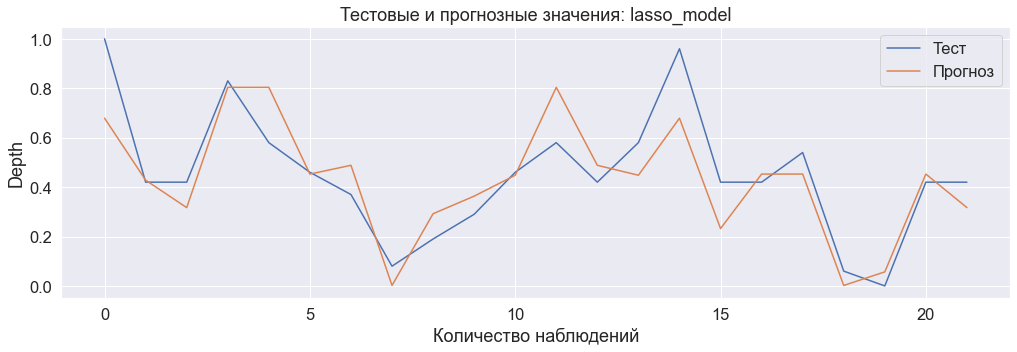

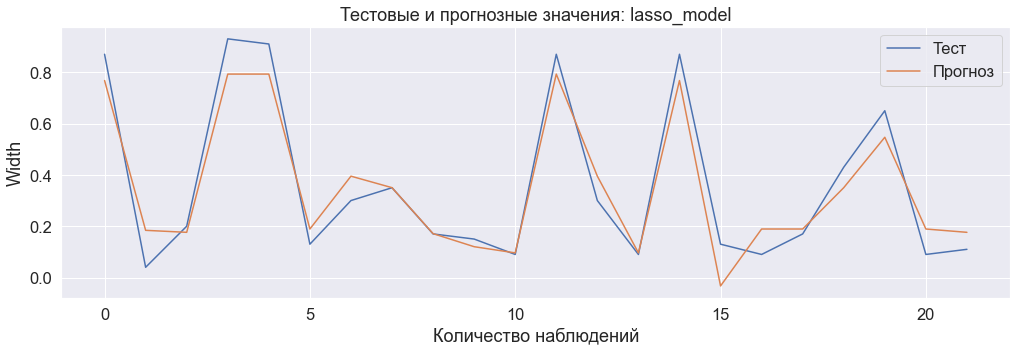

In [19]:
#Визуализация
actual_and_predicted_plot(y_output_depth.values, lasso_model_depth.predict(X_output_depth), 'Depth', 'lasso_model')
actual_and_predicted_plot(y_output_width.values, lasso_model_width.predict(X_output_width), 'Width', 'lasso_model')     

In [20]:
#Многослойный перцептрон
mlpr_model = MLPRegressor(random_state=14)
mlpr_model_params = {
    'hidden_layer_sizes' : [(100, 100, 50, 25, 12), (144, 144, 72, 36, 12, 1), (12, 12, 12, 12, 12),
    (144, 144, 144, 72, 72, 36, 36), ()],
    'activation' : ['identity', 'logistic', 'tanh', 'relu'],
    'solver' : ['sgd', 'adam'],
    'max_iter' : [100],
    'learning_rate' : ['constant', 'adaptive', 'invscaling']
}
GSCV_mlpr_model_depth = GridSearchCV(mlpr_model, mlpr_model_params, n_jobs=-1, cv=10)
GSCV_mlpr_model_depth.fit(X_input_depth, y_input_depth)
# GSCV_mlpr_model_depth.best_params_
mlpr_model_depth = GSCV_mlpr_model_depth.best_estimator_
MSE_depth = mean_squared_error(y_output_depth, mlpr_model_depth.predict(X_output_depth))
R2_depth = r2_score(y_output_depth, mlpr_model_depth.predict(X_output_depth))
GSCV_mlpr_model_width = GridSearchCV(mlpr_model, mlpr_model_params, n_jobs=-1, cv=10)
GSCV_mlpr_model_width.fit(X_input_width, y_input_width)
# GSCV_mlpr_model_width.best_params_
mlpr_model_width = GSCV_mlpr_model_width.best_estimator_
MSE_width = mean_squared_error(y_output_width, mlpr_model_width.predict(X_output_width))
R2_width = r2_score(y_output_width, mlpr_model_width.predict(X_output_width))
mlpr_model_errors = pd.DataFrame({'model_name':'MLPRegressor',\
                                  'target_var':['Depth', 'Width'],\
                                  'MSE':[MSE_depth, MSE_width],\
                                  'R2':[R2_depth, R2_width]})
errors_df = pd.concat([errors_df, mlpr_model_errors], ignore_index=True)
errors_df

,target_var,model_name,MSE,R2
0,Depth,Linear Regression,0.018814,0.696409
1,Width,Linear Regression,0.004331,0.95685
2,Depth,lasso_model,0.018814,0.696409
3,Width,lasso_model,0.007785,0.922442
4,Depth,MLPRegressor,0.011047,0.821738
5,Width,MLPRegressor,0.002027,0.979802


In [21]:
#Параметры модели по сетке
GSCV_mlpr_model_depth.best_params_
GSCV_mlpr_model_width.best_params_
print(mlpr_model_depth.predict(X_output_depth))
mlpr_model_width.predict(X_output_width)

[0.78030692 0.36688032 0.33312068 0.78183782 0.78183782 0.44720405
 0.41723415 0.02657951 0.2784943  0.3552141  0.54071583 0.78183782
 0.41723415 0.54071583 0.78030692 0.27349845 0.44720405 0.44720405
 0.02657951 0.05197091 0.44720405 0.33312068]


array([0.92333108, 0.14039035, 0.13057435, 0.92188772, 0.92188772,
       0.1295688 , 0.31628264, 0.42937953, 0.14275592, 0.10914346,
       0.07775627, 0.92188772, 0.31628264, 0.07775627, 0.92333108,
       0.0505074 , 0.1295688 , 0.1295688 , 0.42937953, 0.64202852,
       0.1295688 , 0.13057435])

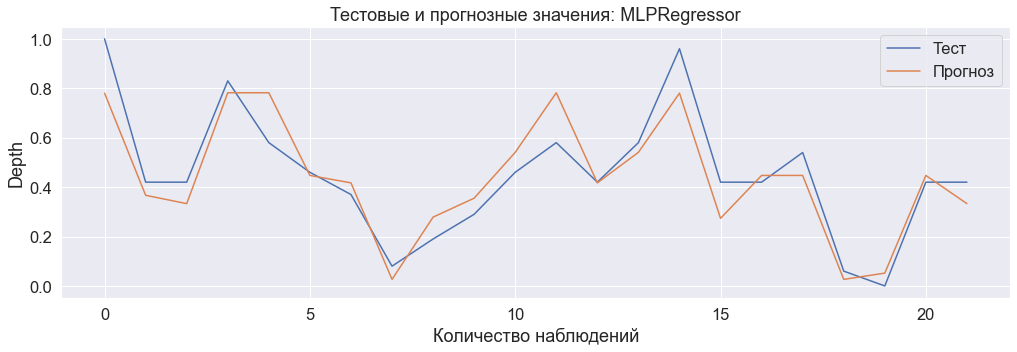

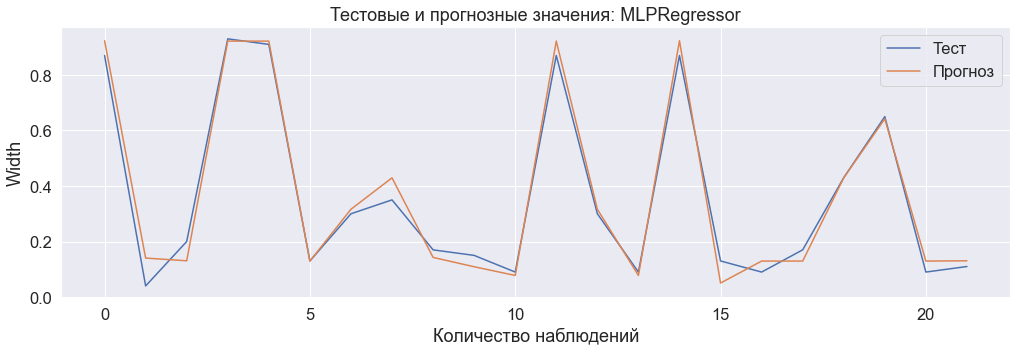

In [22]:
#Визуализация
actual_and_predicted_plot(y_output_depth.values, mlpr_model_depth.predict(X_output_depth), 'Depth', 'MLPRegressor')
actual_and_predicted_plot(y_output_width.values, mlpr_model_width.predict(X_output_width), 'Width', 'MLPRegressor')

Из трёх алгоритмов для приложения выберем наиболее результативную - MLP Regression. Ее MSE наименьшее, а R2 наибольшее.

Сохраняем модель, чтобы в дальнейшем использовать её в приложении.

In [23]:
pickle.dump(mlpr_model_width, open('mlpr_model.pkl', 'wb'))

In [24]:
model_load = pickle.load(open('mlpr_model.pkl', 'rb'))

In [25]:
model_load.predict(X_output_width)

array([0.92333108, 0.14039035, 0.13057435, 0.92188772, 0.92188772,
       0.1295688 , 0.31628264, 0.42937953, 0.14275592, 0.10914346,
       0.07775627, 0.92188772, 0.31628264, 0.07775627, 0.92333108,
       0.0505074 , 0.1295688 , 0.1295688 , 0.42937953, 0.64202852,
       0.1295688 , 0.13057435])

In [26]:
pickle.dump(mlpr_model_depth, open('mlpr_model2.pkl', 'wb'))

In [27]:
model_load2 = pickle.load(open('mlpr_model2.pkl', 'rb'))

In [28]:
model_load2.predict(X_output_depth)

array([0.78030692, 0.36688032, 0.33312068, 0.78183782, 0.78183782,
       0.44720405, 0.41723415, 0.02657951, 0.2784943 , 0.3552141 ,
       0.54071583, 0.78183782, 0.41723415, 0.54071583, 0.78030692,
       0.27349845, 0.44720405, 0.44720405, 0.02657951, 0.05197091,
       0.44720405, 0.33312068])